# TUNet TL

In [1]:
'''
IMPORTS
'''
import tensorflow as tf
from tensorflow.image import resize, ResizeMethod

import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import random
import os
import time
from numpy import load
import numpy as np
import matplotlib.pyplot as plt

'''
DATA PATHS
'''
TOP_DIR = '/tf/Notebooks/Iwashita'

TRAIN_DIR = TOP_DIR + '/Data/Preprocessed_wAugmentation/Experiment1/Train'
VAL_DIR = TOP_DIR + '/Data/Preprocessed_wAugmentation/Experiment1/Validate'
TEST_DIR = TOP_DIR + '/Data/Preprocessed_wAugmentation/Experiment1/Test'

'''
OUTPUTS PATH
'''
WEIGHTS_PATH = TOP_DIR + '/Output/Weights/'
METRICS_PATH = TOP_DIR + '/Output/Metrics/'

'''
GPU
'''
gpu_p40 = '/device:GPU:1'
gpu_1660 = '/device:GPU:0'

!nvidia-smi

'''
TRAINING DATA
'''
print(TRAIN_DIR)
!cd /tf/Notebooks/Iwashita/Data/Preprocessed_wAugmentation/Experiment1/Train && ls

exp1_rgb_X_train = load(TRAIN_DIR + '/exp1_rgb_X_train.npy')
exp1_ir_X_train = load(TRAIN_DIR + '/exp1_ir_X_train.npy')
exp1_y_train = load(TRAIN_DIR + '/exp1_y_train.npy')

'''
VALIDATION DATA
'''
exp1_rgb_X_val = load(VAL_DIR + '/exp1_rgb_X_val.npy')
exp1_ir_X_val = load(VAL_DIR + '/exp1_ir_X_val.npy')
exp1_y_val =load(VAL_DIR + '/exp1_y_val.npy')

'''
TEST DATA
'''
exp1_rgb_X_test = load(TEST_DIR + '/exp1_rgb_X_test.npy')
exp1_ir_X_test = load(TEST_DIR + '/exp1_ir_X_test.npy')
exp1_y_test =load(TEST_DIR + '/exp1_y_test.npy')

'''
INTERSECTION OVER UNION
'''
def iou(y_true, y_pred, num_classes):
    intersection = np.histogram2d(y_true.flatten(), y_pred.flatten(), bins=num_classes)[0]
    area_true = np.histogram(y_true, bins=num_classes)[0]
    area_pred = np.histogram(y_pred, bins=num_classes)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection

    union[union == 0] = 1e-9
    iou = intersection / union

    return iou, np.mean(np.diag(iou))

'''
PIXEL ACCURACY
'''
def pixel_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / y_true.size

'''
MEAN ACCURACY
'''
def mean_accuracy(y_true, y_pred, num_classes):
    intersection = np.histogram2d(y_true.flatten(), y_pred.flatten(), bins=num_classes)[0]
    area_true = np.histogram(y_true, bins=num_classes)[0]

    area_true[area_true == 0] = 1e-9
    accuracy = np.diag(intersection) / area_true

    return np.mean(accuracy)

'''
FIRM-WEIGHT INTERSECTION OVER UNION
'''
def fw_iou(y_true, y_pred, num_classes):
    intersection = np.histogram2d(y_true.flatten(), y_pred.flatten(), bins=num_classes)[0]
    area_true = np.histogram(y_true, bins=num_classes)[0]
    area_pred = np.histogram(y_pred, bins=num_classes)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection

    union[union == 0] = 1e-9
    iou = intersection / union
    fw_iou = np.sum(area_true * iou) / np.sum(area_true)

    return fw_iou

def display_one_hot_annotation(annotations_onehot):
    label = np.argmax(annotations_onehot, axis=-1)
    cmap = plt.get_cmap('tab10', 7)

    plt.imshow(label, cmap=cmap)
    plt.colorbar(ticks=range(num_classes), format=plt.FuncFormatter(lambda val, loc: {
        0: "unlabeled",
        1: "sand",
        2: "soil",
        3: "ballast",
        4: "rock",
        5: "bedrock",
        6: "rocky terrain"
    }[val]))
    plt.show()

print("Done")

2023-07-15 20:26:24.287350: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Sat Jul 15 20:26:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:05:00.0 Off |                  Off |
| N/A   29C    P8     9W / 250W |      4MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 44%   

In [2]:
'''
MODEL PARAMS
'''
BATCH_SIZE = 2
EPOCHS = 1000 

LEARNING_RATE = 1e-4
PATIENCE = 15
FACTOR = 0.1

EXP1_FILENAME = "augmented_tunet_tl_exp1_batch{}_epoch{}_lr{}_p{}_f{}".format(
    BATCH_SIZE, EPOCHS, LEARNING_RATE, PATIENCE, FACTOR)

print("Done")

Done


### TUNet TL Common

In [3]:
'''
MODEL
'''
def ContractionPath(inputs, _padding='same', _activation='relu'):
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.25)(p1)

    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.5)(p2)

    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.5)(p3)

    c4 = Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = Conv2D(512, (3, 3), activation="relu", padding="same")(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.5)(p4)
    
    '''
    RETURN
    '''
    return c1, c2, c3, c4, p4

def ExpansionPath(c1, c2, c3, c4, p4, _padding='same', _activation='relu'):    
    cm = Conv2D(1024, (3, 3), activation="relu", padding="same")(p4)
    cm = Conv2D(1024, (3, 3), activation="relu", padding="same")(cm)
    
    deconv4 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding="same")(cm)
    c4 = resize(c4, (deconv4.shape[1], deconv4.shape[2]), method=ResizeMethod.BILINEAR)
    uconv4 = concatenate([deconv4, c4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(512, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(512, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(uconv4)
    c3 = resize(c3, (deconv3.shape[1], deconv3.shape[2]), method=ResizeMethod.BILINEAR)
    uconv3 = concatenate([deconv3, c3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(256, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(256, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(uconv3)
    c2 = resize(c2, (deconv2.shape[1], deconv2.shape[2]), method=ResizeMethod.BILINEAR)
    uconv2 = concatenate([deconv2, c2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(uconv2)
    c1 = resize(c1, (deconv1.shape[1], deconv1.shape[2]), method=ResizeMethod.BILINEAR)
    uconv1 = concatenate([deconv1, c1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(uconv1)
    
    return uconv1

def TUNet_TL():
    '''
    INPUT
    '''
    # Expected inputs are an RGB and an IR image
    input_rgb = Input((572, 572, 3))
    input_ir = Input((572, 572))
    input_ir = tf.expand_dims(input_ir, axis=-1)
    
    '''
    CONTRACTION PATH
    '''
    c1_rgb, c2_rgb, c3_rgb, c4_rgb, p4_rgb = ContractionPath(input_rgb)
    c1_ir, c2_ir, c3_ir, c4_ir, p4_ir = ContractionPath(input_ir)
    
    '''
    EXPANSION PATH
    '''
    cout_rgb = ExpansionPath(c1_rgb, c2_rgb, c3_rgb, c4_rgb, p4_rgb)
    cout_ir = ExpansionPath(c1_ir, c2_ir, c3_ir, c4_ir, p4_ir)
    
    cout_cat = concatenate([cout_rgb, cout_ir], axis=-1)

    '''
    OUTPUT
    '''
    softmax_output = Conv2D(7, (1, 1), padding="same", activation='softmax')(cout_cat)
    softmax_output = resize(softmax_output, (572, 572), method=ResizeMethod.BILINEAR)

    '''
    RETURN
    '''
    return Model(inputs=[input_rgb, input_ir], outputs=softmax_output)

'''
TRAIN
'''
def TUNet_Train(model, weights_filename, 
               X_rgb_train, X_ir_train, y_train, 
               X_rgb_val, X_ir_val, y_val):

    try:
        with tf.device(gpu_p40):
            
            model.compile(
                optimizer=Adam(learning_rate=LEARNING_RATE), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

            callbacks = [
                ModelCheckpoint(weights_filename, save_best_only=True, save_weights_only=True, verbose=1),
                EarlyStopping(patience=PATIENCE, verbose=1),
                ReduceLROnPlateau(factor=FACTOR, patience=PATIENCE, min_lr=LEARNING_RATE, verbose=1)]
    
            history = model.fit(
                [X_rgb_train, X_ir_train], y_train,
                validation_data=([X_rgb_val, X_ir_val], y_val),
                batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks, verbose=2)
        
    except RuntimeError as e:
        print(e)
        
'''
SCORE
'''
def TUNet_Score(model, weights_filename, metrics_filename, 
                X_rgb_test, X_ir_test, y_test):
    
    try:
        with tf.device(gpu_p40):
            model.load_weights(weights_filename)

            score = model.evaluate([X_rgb_test, X_ir_test], y_test, verbose=0)

            print("Test loss:", score[0])
            print("Test accuracy:", score[1])

            with open(metrics_filename, "a") as f:
                f.write(f"\Test Loss: {score[0]}\n")
                f.write(f"\Test Accuracy: {score[1]}\n")
                
    except RuntimeError as e:
        print(e)

'''
PREDICT
'''
def TUNet_Predict(model, X_rgb_test, X_ir_test):
    try:
        with tf.device(gpu_p40):
            pred = model.predict([X_rgb_test, X_ir_test])
            
    except RuntimeError as e:
        print(e)
        
    return pred

'''
DISPLAY RANDOM RESULT
'''
def TUNet_Display(X_rgb_test, X_ir_test, y_test, y_pred):
    fig, axes = plt.subplots(1, 4, figsize=(10, 6))
    n = random.randint(0, len(X_rgb_test)-1)
    cmap = plt.get_cmap('tab10', 7)
    
    axes[0].imshow(X_rgb_test[n])
    axes[1].imshow(X_ir_test[n], cmap='gray')
    axes[2].imshow(np.argmax(y_test[n], axis=-1), cmap=cmap)
    axes[3].imshow(np.argmax(y_pred[n], axis=-1), cmap=cmap)
                                           
    axes[0].set_title("RGB")
    axes[1].set_title("IR")
    axes[2].set_title("Annotation")
    axes[3].set_title("Predicted")
    
    for ax in axes.flatten():
        ax.axis("off")
        
    plt.tight_layout()
    plt.show()
        
'''
CALCULATE METRICS
'''
def TUNet_Metrics(y_test, y_pred, metrics_filename):
    y_pred_classes = np.argmax(y_pred, axis=-1)
    y_true_classes = np.argmax(y_test, axis=-1)
    
    num_classes = 7
    
    iou_values, mean_iou = iou(y_true_classes, y_pred_classes, num_classes)
    pixel_acc = pixel_accuracy(y_true_classes, y_pred_classes)
    mean_acc = mean_accuracy(y_true_classes, y_pred_classes, num_classes)
    fw_iou_value = fw_iou(y_true_classes, y_pred_classes, num_classes)
    
    print(f"Mean IoU: {mean_iou}")
    print(f"Pixel accuracy: {pixel_acc}")
    print(f"Mean accuracy: {mean_acc}")
    print(f"Frequency-Weighted IoU: {fw_iou_value}")
    
    with open(metrics_filename, "a") as f:
        f.write("\nIoU Values:\n")
        
        for i, iou_val in enumerate(iou_values):
            f.write(f"Class {i}: {iou_val}\n")
        f.write(f"\nMean IoU: {mean_iou}\n")
        f.write(f"Pixel Accuracy: {pixel_acc}\n")
        f.write(f"Mean Accuracy: {mean_acc}\n")
        f.write(f"Frequency Weighted IoU: {fw_iou_value}\n")
    
print("Done")

Done


In [5]:
exp1_model = TUNet_TL()

In [6]:
TUNet_Train(exp1_model, os.path.join(WEIGHTS_PATH, EXP1_FILENAME + '.h5'), 
                exp1_rgb_X_train, exp1_ir_X_train, exp1_y_train,
                exp1_rgb_X_val, exp1_ir_X_val, exp1_y_val)

print("Done")

Epoch 1/1000


2023-07-15 20:27:19.149268: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-15 20:27:20.073121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600



Epoch 1: val_loss improved from inf to 1.72875, saving model to /tf/Notebooks/Iwashita/Output/Weights/augmented_tunet_tl_exp1_batch2_epoch1000_lr0.0001_p15_f0.1.h5
28/28 - 56s - loss: 1.7189 - accuracy: 0.3149 - val_loss: 1.7288 - val_accuracy: 0.3014 - lr: 1.0000e-04 - 56s/epoch - 2s/step
Epoch 2/1000

Epoch 2: val_loss improved from 1.72875 to 1.66734, saving model to /tf/Notebooks/Iwashita/Output/Weights/augmented_tunet_tl_exp1_batch2_epoch1000_lr0.0001_p15_f0.1.h5
28/28 - 40s - loss: 1.5785 - accuracy: 0.3372 - val_loss: 1.6673 - val_accuracy: 0.2816 - lr: 1.0000e-04 - 40s/epoch - 1s/step
Epoch 3/1000

Epoch 3: val_loss improved from 1.66734 to 1.66654, saving model to /tf/Notebooks/Iwashita/Output/Weights/augmented_tunet_tl_exp1_batch2_epoch1000_lr0.0001_p15_f0.1.h5
28/28 - 40s - loss: 1.5498 - accuracy: 0.3838 - val_loss: 1.6665 - val_accuracy: 0.2813 - lr: 1.0000e-04 - 40s/epoch - 1s/step
Epoch 4/1000

Epoch 4: val_loss improved from 1.66654 to 1.65814, saving model to /tf/Note

28/28 - 40s - loss: 1.0943 - accuracy: 0.5771 - val_loss: 1.1108 - val_accuracy: 0.6024 - lr: 1.0000e-04 - 40s/epoch - 1s/step
Epoch 35/1000

Epoch 35: val_loss did not improve from 1.11083
28/28 - 39s - loss: 1.0943 - accuracy: 0.5970 - val_loss: 1.1859 - val_accuracy: 0.5603 - lr: 1.0000e-04 - 39s/epoch - 1s/step
Epoch 36/1000

Epoch 36: val_loss did not improve from 1.11083
28/28 - 39s - loss: 1.0609 - accuracy: 0.5786 - val_loss: 1.1350 - val_accuracy: 0.5834 - lr: 1.0000e-04 - 39s/epoch - 1s/step
Epoch 37/1000

Epoch 37: val_loss did not improve from 1.11083
28/28 - 39s - loss: 1.0771 - accuracy: 0.5507 - val_loss: 1.1349 - val_accuracy: 0.5534 - lr: 1.0000e-04 - 39s/epoch - 1s/step
Epoch 38/1000

Epoch 38: val_loss did not improve from 1.11083
28/28 - 39s - loss: 1.0540 - accuracy: 0.5716 - val_loss: 1.1741 - val_accuracy: 0.5553 - lr: 1.0000e-04 - 39s/epoch - 1s/step
Epoch 39/1000

Epoch 39: val_loss did not improve from 1.11083
28/28 - 38s - loss: 1.0634 - accuracy: 0.5770 - va

Epoch 72/1000

Epoch 72: val_loss did not improve from 0.82335
28/28 - 39s - loss: 0.7740 - accuracy: 0.6950 - val_loss: 0.9532 - val_accuracy: 0.6187 - lr: 1.0000e-04 - 39s/epoch - 1s/step
Epoch 73/1000

Epoch 73: val_loss did not improve from 0.82335
28/28 - 39s - loss: 0.7006 - accuracy: 0.7304 - val_loss: 0.8314 - val_accuracy: 0.6629 - lr: 1.0000e-04 - 39s/epoch - 1s/step
Epoch 74/1000

Epoch 74: val_loss improved from 0.82335 to 0.79141, saving model to /tf/Notebooks/Iwashita/Output/Weights/augmented_tunet_tl_exp1_batch2_epoch1000_lr0.0001_p15_f0.1.h5
28/28 - 41s - loss: 0.7299 - accuracy: 0.7165 - val_loss: 0.7914 - val_accuracy: 0.6932 - lr: 1.0000e-04 - 41s/epoch - 1s/step
Epoch 75/1000

Epoch 75: val_loss did not improve from 0.79141
28/28 - 39s - loss: 0.6827 - accuracy: 0.7362 - val_loss: 0.8188 - val_accuracy: 0.6869 - lr: 1.0000e-04 - 39s/epoch - 1s/step
Epoch 76/1000

Epoch 76: val_loss did not improve from 0.79141
28/28 - 39s - loss: 0.7035 - accuracy: 0.7260 - val_loss

Epoch 111/1000

Epoch 111: val_loss did not improve from 0.66127
28/28 - 39s - loss: 0.4072 - accuracy: 0.8558 - val_loss: 0.6735 - val_accuracy: 0.7577 - lr: 1.0000e-04 - 39s/epoch - 1s/step
Epoch 112/1000

Epoch 112: val_loss did not improve from 0.66127
28/28 - 39s - loss: 0.3550 - accuracy: 0.8794 - val_loss: 0.7565 - val_accuracy: 0.7492 - lr: 1.0000e-04 - 39s/epoch - 1s/step
Epoch 113/1000

Epoch 113: val_loss did not improve from 0.66127
28/28 - 39s - loss: 0.3484 - accuracy: 0.8811 - val_loss: 0.7949 - val_accuracy: 0.7429 - lr: 1.0000e-04 - 39s/epoch - 1s/step
Epoch 114/1000

Epoch 114: val_loss did not improve from 0.66127
28/28 - 39s - loss: 0.3479 - accuracy: 0.8827 - val_loss: 0.7504 - val_accuracy: 0.7542 - lr: 1.0000e-04 - 39s/epoch - 1s/step
Epoch 115/1000

Epoch 115: val_loss did not improve from 0.66127
28/28 - 39s - loss: 0.3358 - accuracy: 0.8850 - val_loss: 0.7371 - val_accuracy: 0.7516 - lr: 1.0000e-04 - 39s/epoch - 1s/step
Epoch 116/1000

Epoch 116: val_loss did 

In [7]:
score = TUNet_Score(
    exp1_model, 
    os.path.join(WEIGHTS_PATH, EXP1_FILENAME + '.h5'),
    os.path.join(METRICS_PATH, EXP1_FILENAME + '.txt'),
    exp1_rgb_X_test,
    exp1_ir_X_test,
    exp1_y_test)

2023-07-15 21:46:28.572738: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_1_bfc) ran out of memory trying to allocate 2.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-15 21:46:28.572774: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2023-07-15 21:46:28.669066: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_1_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-15 21:46:29.363234: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_1_bfc) ran out of 

Test loss: 0.5863282084465027
Test accuracy: 0.7888569235801697


In [8]:
y_pred = TUNet_Predict(exp1_model, exp1_rgb_X_test, exp1_ir_X_test)

1/1 [==============================] - 3s 3s/step


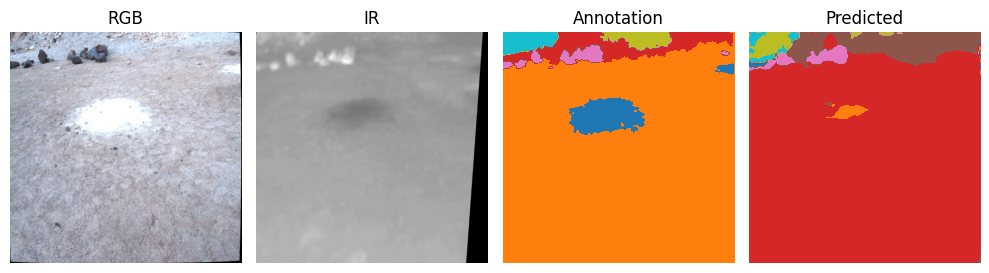

In [13]:
TUNet_Display(exp1_rgb_X_test, exp1_ir_X_test, exp1_y_test, y_pred)

In [10]:
TUNet_Metrics(exp1_y_test, y_pred, os.path.join(METRICS_PATH, EXP1_FILENAME + '.txt'))

Mean IoU: 0.581345692833069
Pixel accuracy: 0.7888567944293469
Mean accuracy: 0.7174750907796925
Frequency-Weighted IoU: 0.7629330991165496
